In [4]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#!conda install -c conda-forge opencv -y
import cv2 
from utils import *
from utils.utils import *
from models import Darknet
import sys
sys.path.append(os.getcwd() + '/..')
!pip install shapely
from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

ModuleNotFoundError: No module named 'yolov3'

In [ ]:
device = "cuda"
torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [ ]:
labeled_scene_index = np.arange(106, 134)
random.shuffle(labeled_scene_index)
labeled_scene_index_train = labeled_scene_index[0:21]
labeled_scene_index_val = labeled_scene_index[21:28]
transform = torchvision.transforms.ToTensor()
print("Train scenes: {} \nVal scenes: {}".format(len(labeled_scene_index_train), len(labeled_scene_index_val)))
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_train,
                                  transform=transform,
                                  extra_info=False
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_val,
                                  transform=transform,
                                  extra_info=False
                                 )
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [2]:
#config = "cfg/yolov3-tiny-3cls.cfg"
config = "cfg/yolov3-spp.cfg"
hyp = {'giou': 3.54,  # giou loss gain
       'cls': 0,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 64.3,  # obj loss gain (*=img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.20,  # iou training threshold
       'lr0': 0.0001,  # initial learning rate (SGD=5E-3, Adam=5E-4)
       'lrf': 0.00005,  # final learning rate (with cos scheduler)
       'momentum': 0.937,  # SGD momentum
       'weight_decay': 0.000484,  # optimizer weight decay
       'fl_gamma': 0.0,  # focal loss gamma (efficientDet default is gamma=1.5)
       'hsv_h': 0.0138,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.678,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 1.98 * 0,  # image rotation (+/- deg)
       'translate': 0.05 * 0,  # image translation (+/- fraction)
       'scale': 0.05 * 0,  # image scale (+/- gain)
       'shear': 0.641 * 0}  # image shear (+/- deg)

In [3]:
model_file2 = 'best_bounding_box.pt'
model = Darknet(config, verbose=False).to(device)
checkpoint2 = torch.load(model_file2)
model.load_state_dict(checkpoint2['model_state_dict'])

NameError: name 'Darknet' is not defined

In [27]:
checkpoint2.keys()

dict_keys(['epoch', 'config', 'model_state_dict', 'conv_state_dict', 'optimizer_state_dict', 'val_loss'])

In [5]:
from __future__ import print_function
from collections import OrderedDict
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 3*256*306
d = 20
s = 300

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size= (7,3), stride= 3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 3, stride= 3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 3, stride= 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= 5, stride= 3),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size= 3, stride= 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2,True)
        )
        self.l1=nn.Sequential(
            nn.Linear(1024*48, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, s * 2)
        )
        self.l2=nn.Sequential(
            nn.Linear(s, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 1024*48)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=3),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.ConvTranspose2d(64, 3, kernel_size=(7,3), stride=3),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        enc = self.encoder(x)
        mu_logvar = self.l1(enc.view(len(x),-1)).view(-1, 2, s)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        dec = self.decoder(self.l2(z).view(len(z),1024, 6, 8))
        return dec, mu, logvar

model_vae = VAE().to(device)
checkpoint = torch.load('/home/yt1526/VAE')
model_vae.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
class conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(18, 3, kernel_size = (3, 3), padding=1)
    def forward(self, x):
        return self.conv(x)

In [30]:
conv = conv().to(device)
conv.load_state_dict(checkpoint2['conv_state_dict'])

<All keys matched successfully>

In [8]:
pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
for k, v in dict(model.named_parameters()).items():
    if '.bias' in k:
        if v.is_leaf:
            pg2 += [v]  # biases
    elif 'Conv2d.weight' in k:
        pg1 += [v]  # apply weight_decay
    else:
        pg0 += [v]  # all else

optimizer = optim.Adam(list(pg0)+list(conv.parameters()), lr=hyp['lr0'])
optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
del pg0, pg1, pg2

In [9]:
device = "cuda"
def train(train_loader, model, optimizer, criterion, epoch):
    
    model.train()

    for batch_idx, (sample, target, road_image) in enumerate(train_loader):
        # Rework target into expected format:
        # A tensor of size [B, 6]
        # where B is the total # of bounding boxes for all observvations in the batch 
        # and 6 is [id, class, x, y, w, h] (class is always 0, since we're not doing classification)
        # Target is originally front left, front right, back left and back right
        # Note: for boxes not aligned with the x-y axis, this will draw a box with the same center but a maximal width-height that *is* aligned
        # The original range is xy values from from -40 to 40. We also rescale so that x values are from 0 to 1
        target_yolo = torch.zeros(0,6)
        for i, obs in enumerate(target):
            boxes = (obs['bounding_box'] + 40)/80
            boxes_yolo = torch.zeros(boxes.shape[0], 6)
            for box in range(boxes.shape[0]):
                cls = 0
                x_center = 0.5*(boxes[box, 0, 0] + boxes[box, 0, 3])
                y_center = 0.5*(boxes[box, 1, 0] + boxes[box, 1, 3])
                width = max(boxes[box, 0, :]) - min(boxes[box, 0, :])
                height = max(boxes[box, 1, :]) - min(boxes[box, 1, :])
                boxes_yolo[box] = torch.tensor([i, cls, x_center, y_center, width, height])
            target_yolo = torch.cat((target_yolo, boxes_yolo), 0)
        sample = torch.stack(sample).to(device)
        batch_size = sample.shape[0]
        sample = sample.view(batch_size, 18, 256, 306)
        sample = conv(sample)
        target_yolo = target_yolo.to(device)
        # Run through model
        optimizer.zero_grad()
        output = model(sample)

        # Calculate loss and take step
        loss, loss_items = compute_loss(output, target_yolo, model, hyp) # Note: this is defined in yolov3.py
        if not torch.isfinite(loss):
            print('WARNING: non-finite loss.')
        loss.backward()
        optimizer.step()

        # Log progress
        if batch_idx % 100 == 0:
            print('\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                
    return

In [10]:
def evaluate(val_loader, model):
    model.eval()
    losses = []
    tp, fp, fn = 0, 0, 0
    for batch_idx, (sample, target, road_image) in enumerate(val_loader):
        
        # Rework target into expected format:
        # A tensor of size [B, 6]
        # where B is the total # of bounding boxes for all observvations in the batch 
        # and 6 is [id, class, x, y, w, h] (class is always 0, since we're not doing classification)
        # Target is originally front left, front right, back left and back right
        # Note: for boxes not aligned with the x-y axis, this will draw a box with the same center but a maximal width-height that *is* aligned
        # The original range is xy values from from -40 to 40. We also rescale so that x values are from 0 to 1
        # "Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height."
        target_yolo = torch.zeros(0,6)
        for i, obs in enumerate(target):
            boxes = (obs['bounding_box'] + 40)/80
            boxes_yolo = torch.zeros(boxes.shape[0], 6)
            for box in range(boxes.shape[0]):
                cls = 0
                x_center = 0.5*(boxes[box, 0, 0] + boxes[box, 0, 3])
                y_center = 0.5*(boxes[box, 1, 0] + boxes[box, 1, 3])
                width = max(boxes[box, 0, :]) - min(boxes[box, 0, :])
                height = max(boxes[box, 1, :]) - min(boxes[box, 1, :])
                boxes_yolo[box] = torch.tensor([i, cls, x_center, y_center, width, height])
            target_yolo = torch.cat((target_yolo, boxes_yolo), 0)
        
        sample = torch.stack(sample).to(device)
        batch_size = sample.shape[0]
        sample = sample.view(batch_size, 18, 256, 306)
        sample = conv(sample)
        target_yolo = target_yolo.to(device)
        # Run through model
        with torch.no_grad():
            output = model(sample)
        loss, loss_items = compute_loss(output[1], target_yolo, model, hyp) # Note: this is defined in yolov3.py
        losses.append(loss)
    
    # Calculate metrics
    loss = sum(losses)/len(losses)
    
    return loss

In [11]:
val_loss_hist = []
for epoch in range(30):
    
    # Train for one epoch
    train(trainloader, model, optimizer, None, epoch)
    
    # Evaluate at the end of the epoch
    print("Evaluating after Epoch {}:".format(epoch))
    model.training= False
    val_loss = evaluate(valloader, model)
    model.training=True
    print("Val loss is {}".format(val_loss.cpu().detach()))
    min_val_loss = float('inf')
    # If this is the best model so far, save it
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'config': config,
            'model_state_dict': model.state_dict(),
            'conv_state_dict': conv.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            }, 'best_bounding_box.pt')
    
    # Save loss 
    val_loss_hist.append(val_loss)
    #val_threat_score_hist.append(val_threat_score)

	Train Epoch: 0 [0/2646 (0%)]	Loss: 7.886873
	Train Epoch: 0 [200/2646 (8%)]	Loss: 3.208977
	Train Epoch: 0 [400/2646 (15%)]	Loss: 3.780180
	Train Epoch: 0 [600/2646 (23%)]	Loss: 4.643973
	Train Epoch: 0 [800/2646 (30%)]	Loss: 8.206614
	Train Epoch: 0 [1000/2646 (38%)]	Loss: 4.041626
	Train Epoch: 0 [1200/2646 (45%)]	Loss: 5.106427
	Train Epoch: 0 [1400/2646 (53%)]	Loss: 2.939772
	Train Epoch: 0 [1600/2646 (60%)]	Loss: 3.744762
	Train Epoch: 0 [1800/2646 (68%)]	Loss: 3.499445
	Train Epoch: 0 [2000/2646 (76%)]	Loss: 4.986573
	Train Epoch: 0 [2200/2646 (83%)]	Loss: 4.469500
	Train Epoch: 0 [2400/2646 (91%)]	Loss: 3.302412
	Train Epoch: 0 [2600/2646 (98%)]	Loss: 2.766295
Evaluating after Epoch 0:
Val loss is tensor([4.91250])
	Train Epoch: 1 [0/2646 (0%)]	Loss: 3.266164
	Train Epoch: 1 [200/2646 (8%)]	Loss: 4.160567
	Train Epoch: 1 [400/2646 (15%)]	Loss: 4.717836
	Train Epoch: 1 [600/2646 (23%)]	Loss: 3.686123
	Train Epoch: 1 [800/2646 (30%)]	Loss: 2.753664
	Train Epoch: 1 [1000/2646 (38%

	Train Epoch: 11 [600/2646 (23%)]	Loss: 1.802421
	Train Epoch: 11 [800/2646 (30%)]	Loss: 2.088045
	Train Epoch: 11 [1000/2646 (38%)]	Loss: 2.584157
	Train Epoch: 11 [1200/2646 (45%)]	Loss: 2.761710
	Train Epoch: 11 [1400/2646 (53%)]	Loss: 4.422080
	Train Epoch: 11 [1600/2646 (60%)]	Loss: 3.029150
	Train Epoch: 11 [1800/2646 (68%)]	Loss: 6.265634
	Train Epoch: 11 [2000/2646 (76%)]	Loss: 5.016338
	Train Epoch: 11 [2200/2646 (83%)]	Loss: 2.080189
	Train Epoch: 11 [2400/2646 (91%)]	Loss: 2.056358
	Train Epoch: 11 [2600/2646 (98%)]	Loss: 2.215338
Evaluating after Epoch 11:
Val loss is tensor([5.57415])
	Train Epoch: 12 [0/2646 (0%)]	Loss: 1.982955
	Train Epoch: 12 [200/2646 (8%)]	Loss: 1.866649
	Train Epoch: 12 [400/2646 (15%)]	Loss: 1.966290
	Train Epoch: 12 [600/2646 (23%)]	Loss: 1.864289
	Train Epoch: 12 [800/2646 (30%)]	Loss: 1.106294
	Train Epoch: 12 [1000/2646 (38%)]	Loss: 2.143059
	Train Epoch: 12 [1200/2646 (45%)]	Loss: 3.379297
	Train Epoch: 12 [1400/2646 (53%)]	Loss: 2.364365
	Tra

	Train Epoch: 22 [600/2646 (23%)]	Loss: 1.169419
	Train Epoch: 22 [800/2646 (30%)]	Loss: 1.104732
	Train Epoch: 22 [1000/2646 (38%)]	Loss: 1.364640
	Train Epoch: 22 [1200/2646 (45%)]	Loss: 1.767231
	Train Epoch: 22 [1400/2646 (53%)]	Loss: 2.164535
	Train Epoch: 22 [1600/2646 (60%)]	Loss: 1.511129
	Train Epoch: 22 [1800/2646 (68%)]	Loss: 0.777685
	Train Epoch: 22 [2000/2646 (76%)]	Loss: 2.408559
	Train Epoch: 22 [2200/2646 (83%)]	Loss: 1.343196
	Train Epoch: 22 [2400/2646 (91%)]	Loss: 1.406842
	Train Epoch: 22 [2600/2646 (98%)]	Loss: 1.560818
Evaluating after Epoch 22:
Val loss is tensor([6.75005])
	Train Epoch: 23 [0/2646 (0%)]	Loss: 2.201466
	Train Epoch: 23 [200/2646 (8%)]	Loss: 1.377552
	Train Epoch: 23 [400/2646 (15%)]	Loss: 1.911509
	Train Epoch: 23 [600/2646 (23%)]	Loss: 1.315960
	Train Epoch: 23 [800/2646 (30%)]	Loss: 1.526100
	Train Epoch: 23 [1000/2646 (38%)]	Loss: 3.481951
	Train Epoch: 23 [1200/2646 (45%)]	Loss: 1.744251
	Train Epoch: 23 [1400/2646 (53%)]	Loss: 1.281623
	Tra

KeyboardInterrupt: 

In [252]:
sample, target, road_image = iter(valloader).next()

In [ ]:
get_bounding_boxes(sample)

In [ ]:
import os
import random
import argparse

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import LabeledDataset
from helper import compute_ats_bounding_boxes, compute_ts_road_map

from model_loader import get_transform_task1, get_transform_task2, ModelLoader

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default='data')
parser.add_argument('--testset', action='store_true')
parser.add_argument('--verbose', action='store_true')
opt = parser.parse_args()

image_folder = opt.data_dir
annotation_csv = f'{opt.data_dir}/annotation.csv'

if opt.testset:
    labeled_scene_index = np.arange(134, 148)
else:
    labeled_scene_index = np.arange(120, 134)

# For bounding boxes task
labeled_trainset_task1 = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=labeled_scene_index,
    transform=get_transform_task1(),
    extra_info=False
    )
dataloader_task1 = torch.utils.data.DataLoader(
    labeled_trainset_task1,
    batch_size=1,
    shuffle=False,
    num_workers=4
    )
# For road map task
labeled_trainset_task2 = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=labeled_scene_index,
    transform=get_transform_task2(),
    extra_info=False
    )
dataloader_task2 = torch.utils.data.DataLoader(
    labeled_trainset_task2,
    batch_size=1,
    shuffle=False,
    num_workers=4
    )

model_loader = ModelLoader()

total = 0
total_ats_bounding_boxes = 0
total_ts_road_map = 0
with torch.no_grad():
    for i, data in enumerate(dataloader_task1):
        total += 1
        sample, target, road_image = data
        sample = sample.cuda()

        predicted_bounding_boxes = model_loader.get_bounding_boxes(sample)[0].cpu()
        ats_bounding_boxes = compute_ats_bounding_boxes(predicted_bounding_boxes, target['bounding_box'][0])
        total_ats_bounding_boxes += ats_bounding_boxes

        if opt.verbose:
            print(f'{i} - Bounding Box Score: {ats_bounding_boxes:.4}')

    for i, data in enumerate(dataloader_task2):
        sample, target, road_image = data
        sample = sample.cuda()

        predicted_road_map = model_loader.get_binary_road_map(sample).cpu()
        ts_road_map = compute_ts_road_map(predicted_road_map, road_image)
        total_ts_road_map += ts_road_map

        if opt.verbose:
            print(f'{i} - Road Map Score: {ts_road_map:.4}')

print(f'{model_loader.team_name} - {model_loader.round_number} - Bounding Box Score: {total_ats_bounding_boxes / total:.4} - Road Map Score: {total_ts_road_map / total:.4}')
    

In [31]:
labeled_scene_index = np.arange(134, 135)
labeled_scene_index_test = labeled_scene_index[0]
transform = torchvision.transforms.ToTensor()
labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index_train,
                                  transform=transform,
                                  extra_info=False
                                 )
testloader = torch.utils.data.DataLoader(labeled_testset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


In [32]:
sample, target, road_image = iter(testloader).next()

In [33]:
target = target[0]

In [34]:
target['bounding_box'].size()

torch.Size([13, 2, 4])

In [35]:
sample = sample[0].view(1, 18, 256, 306)

In [36]:
sample.size()

torch.Size([1, 18, 256, 306])

In [37]:
def get_bounding_boxes(samples):
        # samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
        # You need to return a tuple with size 'batch_size' and each element is a cuda tensor [N, 2, 4]
        # where N is the number of object
        b= []
        model.eval()
        conv.eval()
        batch_size = samples.shape[0]
        sample = samples.view(batch_size, 18, 256, 306).to(device)
        sample = conv(sample)
        pred = model(sample)
        conf_thres = 0.08
        iou_thres = 0.6
        pred = non_max_suppression(pred[0], conf_thres, iou_thres, multi_label=False, classes=None)
        for i, p in enumerate(pred):
            pred[i][:, 0] = p[:, 0] * 80/256 - 40
            pred[i][:, 1] = p[:, 1] * 80/306 - 40
            pred[i][:, 2] = p[:, 2] * 80/256 - 40
            pred[i][:, 3] = p[:, 3] * 80/306 - 40
        box_num = pred[0].size()[0]
        bbox = []
        for i in range(box_num):
            bbox.append(torch.tensor([[max(pred[0][i][2], pred[0][i][0]),  max(pred[0][i][2], pred[0][i][0]), min(pred[0][i][2], pred[0][i][0]),  min(pred[0][i][2], pred[0][i][0])],
            [min(pred[0][i][1],pred[0][i][3]),   max(pred[0][i][1],pred[0][i][3]), max(pred[0][i][1],pred[0][i][3]), min(pred[0][i][1],pred[0][i][3])]]))
        bbox = torch.stack(bbox)
        bbox[bbox>40] = 40
        bbox[bbox<-40] = -40
        b.append(bbox)
        return tuple(b)

In [38]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from shapely.geometry import Polygon

def convert_map_to_lane_map(ego_map, binary_lane):
    mask = (ego_map[0,:,:] == ego_map[1,:,:]) * (ego_map[1,:,:] == ego_map[2,:,:]) + (ego_map[0,:,:] == 250 / 255)

    if binary_lane:
        return (~ mask)
    return ego_map * (~ mask.view(1, ego_map.shape[1], ego_map.shape[2]))

def convert_map_to_road_map(ego_map):
    mask = (ego_map[0,:,:] == 1) * (ego_map[1,:,:] == 1) * (ego_map[2,:,:] == 1)

    return (~mask)

def collate_fn(batch):
    return tuple(zip(*batch))

def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)

def compute_ats_bounding_boxes(boxes1, boxes2):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight
    
    return average_threat_score

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

In [39]:
total = 0
total_ats_bounding_boxes = 0
total_ts_road_map = 0
with torch.no_grad():
    total += 1
    predicted_bounding_boxes = get_bounding_boxes(sample)[0].cpu()
    ats_bounding_boxes = compute_ats_bounding_boxes(predicted_bounding_boxes, target['bounding_box'])
    total_ats_bounding_boxes += ats_bounding_boxes


print(f' - Bounding Box Score: {total_ats_bounding_boxes / total:.4}')

 - Bounding Box Score: 0.0


In [354]:
sample, target, road_image = iter(valloader).next()
model.eval()
sample = torch.stack(sample).to(device)

# Make input the correct shape
batch_size = sample.shape[0]
sample = sample.view(batch_size, 18, 256, 306)
sample = conv(sample)

# Run through model
optimizer.zero_grad()
output = model(sample)
output[0][1, :, 0].max()

tensor(313.64111, device='cuda:0', grad_fn=<MaxBackward1>)

In [355]:

# Apply non-max supression
#Returns list of length batch_size, with each list element being a tensor of size nx6 (x1, y1, x2, y2, conf, cls) 
conf_thres = 0.07
iou_thres = 0.6
output = non_max_suppression(output[0], conf_thres, iou_thres,
                                   multi_label=False, classes=None, )
# Rescale from 256x306 to 80x80 (from -40 to 40)
for i, preds in enumerate(output):
    output[i][:, 0] = preds[:, 0] * 80/256 - 40
    output[i][:, 1] = preds[:, 1] * 80/306 - 40
    output[i][:, 2] = preds[:, 2] * 80/256 - 40
    output[i][:, 3] = preds[:, 3] * 80/306 - 40

In [356]:
output[0].shape

torch.Size([27, 6])

In [357]:
# Store bounding boxes in the correct format
bounding_boxes = torch.zeros((output[0].shape[0], 2, 4))
for i in range(output[0].shape[0]):
    # Get four corners
    bounding_boxes[i, :, :] = torch.tensor([[max(output[0][i][2], output[0][i][0]),  max(output[0][i][2], output[0][i][0]), min(output[0][i][2], output[0][i][0]),  min(output[0][i][2], output[0][i][0])],
                                            [min(output[0][i][1],output[0][i][3]),   max(output[0][i][1],output[0][i][3]), max(output[0][i][1],output[0][i][3]), min(output[0][i][1],output[0][i][3])]])
# Truncate corners that are out of range
bounding_boxes[bounding_boxes>40] = 40
bounding_boxes[bounding_boxes<-40] = -40

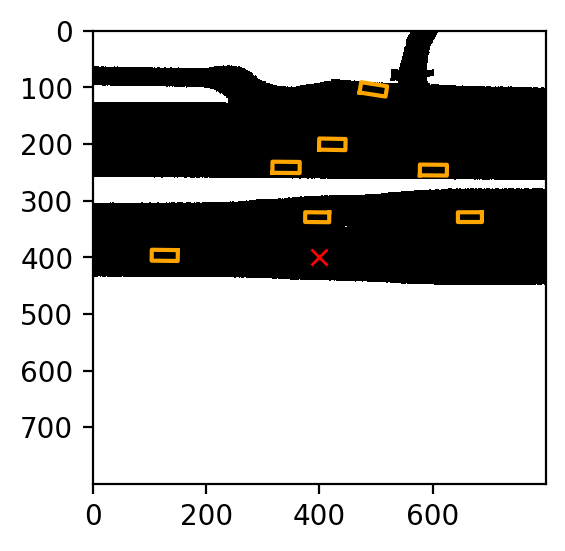

In [358]:

# Plot original
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

IndexError: index 7 is out of bounds for dimension 0 with size 7

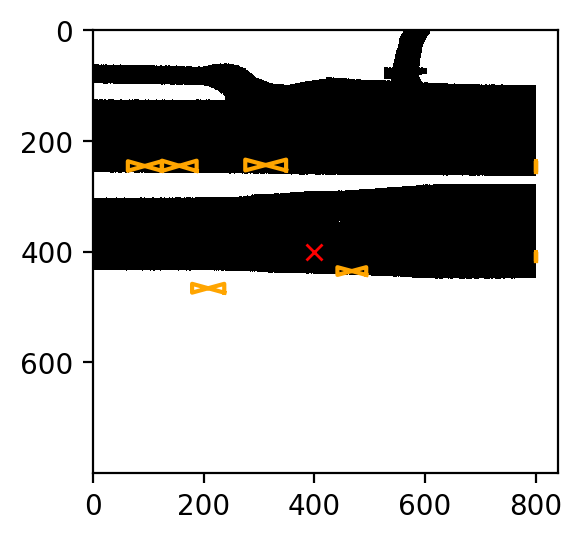

In [359]:
# Plot prediction
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(bounding_boxes):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])